In [1]:
%matplotlib inline  

In [2]:
import torch
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import torch.utils.data as data_utils
import os
import warnings 
warnings.simplefilter("ignore", UserWarning)

In [3]:
os.chdir("..")

In [4]:
from Prior_optimization.gpr import GPR
from Prior_optimization import kernels, mean_functions, priors
from Networks.gaussian_reparam_mlp import GaussianMLPReparameterization
from Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Networks.mlp import MLP
from Samplers.likelihoods import LikGaussian
from Prior_optimization.priors import FixedGaussianPrior, OptimGaussianPrior
from Utilities.rand_generators import MeasureSetGenerator, GridGenerator
from Utilities.normalization import normalize_data
from Utilities.exp_utils import get_input_range
from Metrics.sampling import compute_rhat_regression
from Metrics import uncertainty as uncertainty_metrics
from Networks.regression_net import RegressionNet
from Networks.mlp_masked import MLPMasked
from Networks.regression_net_masked import RegressionNetMasked
from Prior_optimization.sinkhorn_optimisation import SinkhornMapper
from Utilities import util
from Utilities.priors import LogNormal

In [5]:
mpl.rcParams['figure.dpi'] = 100

In [6]:
SEED = 123
util.set_seed(SEED)

In [7]:
# Network architecture
n_units = 100
n_hidden = 1
activation_fn = "tanh"

In [8]:
# Dataset configurations
n_splits = 10
dataset = "boston"
data_dir = "./data/uci"
noise_var = 0.1

# 1. Optimized Gaussian Prior

In [9]:
out_dir = "./exp/uci/optim_gaussian"
util.ensure_dir(out_dir)

## 1.1 Optimize the prior

In [ ]:
num_iters = 200  # Number of iteterations of Wasserstein optimization
lr = 0.05        # The learning rate
n_samples = 128  # The mini-batch size
lambd_sd = torch.tensor([2.]) # Vetcor of penalization terms
D = 3            # Depth for pruning of standard deviations
num_samples = 30
num_iters_sd = 5000
print_every = 100
num_burn_in_steps = 200
n_data = 128

In [11]:
masks_list = []
for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    # Load the dataset
    saved_dir = os.path.join(out_dir, str(split_id))
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    X_train_, y_train_, X_test_, y_test_, y_mean, y_std = normalize_data(
            X_train, y_train, X_test, y_test)
    x_min, x_max = get_input_range(X_train_, X_test_)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    
    # Initialize the measurement set generator
    rand_generator = MeasureSetGenerator(X_train_, x_min, x_max, 0.7)
    
    # Initialize the mean and covariance function of the target hierarchical GP prior
    mean = mean_functions.Zero()
    
    lengthscale = math.sqrt(2. * input_dim)
    variance = 1.
    kernel = kernels.RBF(input_dim=input_dim,
                         lengthscales=torch.tensor([lengthscale], dtype=torch.double),
                         variance=torch.tensor([variance], dtype=torch.double), ARD=True)

    # Place hyper-priors on lengthscales and variances
    kernel.lengthscales.prior = LogNormal(
            torch.ones([input_dim]) * math.log(lengthscale),
            torch.ones([input_dim]) * 1.)
    kernel.variance.prior = LogNormal(
            torch.ones([1]) * 0.1,
            torch.ones([1]) * 1.)
        
    # Initialize the GP model
    gp = GPR(X=torch.from_numpy(X_train_), Y=torch.from_numpy(y_train_).reshape([-1, 1]),
             kern=kernel, mean_function=mean)
    gp.likelihood.variance.set(noise_var)
    
    # Initialize tunable MLP prior
    hidden_dims = [n_units] * n_hidden
    mlp_reparam = FactorizedGaussianMLPReparameterization(input_dim, output_dim,
        hidden_dims, D = D, activation_fn=activation_fn, scaled_variance=True)
    # Perform optimization
    mapper = SinkhornMapper(out_dir=saved_dir)
    y_train_tensor = torch.tensor(y_train)  # Assumes y is 1D: (batch_size,)
    y_train = y_train_tensor[:, None, None].expand(-1, num_samples, 1)
    p_hist, loss_hist = mapper.optimize_sparse(net = mlp_reparam, gp = gp, data_generator = rand_generator, 
            lambd= lambd_sd, n_data = n_data, num_iters = num_iters_sd, print_every=print_every, output_dim = 1, 
            D= D, X_train = torch.tensor(X_train), y_train= y_train, n_samples = num_samples)
    path = os.path.join(saved_dir, "loss_values.log")
    if not os.path.isfile(saved_dir):
        os.makedirs(saved_dir, exist_ok=True)
    np.savetxt(path, loss_hist, fmt='%.6e')
    path = os.path.join(saved_dir, "pruned_values.log")
    if not os.path.isfile(saved_dir):
        os.makedirs(saved_dir, exist_ok=True)
    np.savetxt(path, p_hist, fmt='%.6e')
    print("----" * 20)
    masks_list.append(mlp_reparam.get_det_masks())

Loading split 1 of boston dataset
>>> Iteration #   1: Sinkhorn Dist 40.8609 Number of pruned stochastic weights: 0
>>> Iteration # 100: Sinkhorn Dist 43.6713 Number of pruned stochastic weights: 0
>>> Iteration # 200: Sinkhorn Dist 23.7334 Number of pruned stochastic weights: 0
>>> Iteration # 300: Sinkhorn Dist 28.3756 Number of pruned stochastic weights: 2
>>> Iteration # 400: Sinkhorn Dist 30.2864 Number of pruned stochastic weights: 5
>>> Iteration # 500: Sinkhorn Dist 34.7831 Number of pruned stochastic weights: 7
>>> Iteration # 600: Sinkhorn Dist 18.8343 Number of pruned stochastic weights: 12
>>> Iteration # 700: Sinkhorn Dist 25.3957 Number of pruned stochastic weights: 17
>>> Iteration # 800: Sinkhorn Dist 11.7751 Number of pruned stochastic weights: 24
>>> Iteration # 900: Sinkhorn Dist 11.6134 Number of pruned stochastic weights: 34
>>> Iteration # 1000: Sinkhorn Dist 11.3621 Number of pruned stochastic weights: 55
>>> Iteration # 1100: Sinkhorn Dist 20.9282 Number of prun

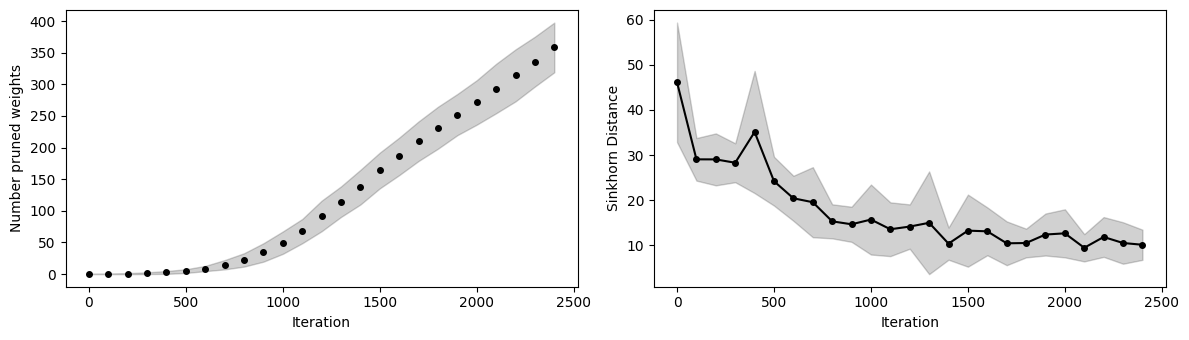

In [12]:
# Visualize the convergence
lossdist_data = []
pruned_vals_data = []
for i in range(0, n_splits):
    lossdist_file = os.path.join(out_dir, str(i), "loss_values.log")
    pruned_vals_file = os.path.join(out_dir, str(i), "pruned_values.log")
    lossdist_data.append(np.loadtxt(lossdist_file))
    pruned_vals_data.append(np.loadtxt(pruned_vals_file))

lossdist_vals = np.stack(lossdist_data)
pruned_vals = np.stack(pruned_vals_data)
indices = np.arange(num_iters_sd)[::100]
mean_loss = lossdist_vals.mean(0)
std_loss = lossdist_vals.std(0)
mean_pruned = pruned_vals.mean(0)
std_pruned = pruned_vals.std(0)

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, mean_pruned[indices], "ko", ms=4)
axes[0].fill_between(indices, mean_pruned[indices] - std_pruned[indices],
                 mean_pruned[indices] + std_pruned[indices], alpha=0.18, color="k")
axes[0].set_ylabel("Number pruned weights")
axes[0].set_xlabel("Iteration")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, mean_loss[indices], "-ko", ms=4)
axes[1].fill_between(indices, mean_loss[indices]-std_loss[indices],
                     mean_loss[indices]+std_loss[indices], alpha = 0.18, color = "k")
axes[1].set_ylabel("Sinkhorn Distance")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()

## 1.2 Posterior Inference

### No Prevention from Overfitting

In [13]:
sampling_configs = {
    "batch_size": 32,                 # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,         # Number of burn-in steps
    "keep_every": 2000,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}

In [14]:
results = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1

    # Initialize the neural network and likelihood modules
    weight_mask, bias_mask = masks_list[split_id]
    net = MLPMasked(input_dim, output_dim, [n_units] * n_hidden, activation_fn, weight_mask, bias_mask)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir, str(split_id), "ckpts", "sparse-it-{}.ckpt".format(num_iters_sd))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNetMasked(net, likelihood, prior, saved_dir, n_gpu=0)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results['rmse'].append(rmse)
    results['nll'].append(nll)

Loading split 1 of boston dataset
Chain: 1
Samples #     5 : NLL =  2.0941e+00 RMSE = 8.6514e-01 
Samples #    10 : NLL =  2.0876e+00 RMSE = 7.1720e-01 
Samples #    15 : NLL =  2.0840e+00 RMSE = 6.3318e-01 
Samples #    20 : NLL =  2.0820e+00 RMSE = 5.8438e-01 
Samples #    25 : NLL =  2.0791e+00 RMSE = 5.4801e-01 
Samples #    30 : NLL =  2.0765e+00 RMSE = 5.2505e-01 
Chain: 2
Samples #    35 : NLL =  2.0796e+00 RMSE = 5.3079e-01 
Samples #    40 : NLL =  2.0813e+00 RMSE = 5.3515e-01 
Samples #    45 : NLL =  2.0830e+00 RMSE = 5.3898e-01 
Samples #    50 : NLL =  2.0840e+00 RMSE = 5.4111e-01 
Samples #    55 : NLL =  2.0844e+00 RMSE = 5.4900e-01 
Samples #    60 : NLL =  2.0849e+00 RMSE = 5.5475e-01 
Chain: 3
Samples #    65 : NLL =  2.0863e+00 RMSE = 5.5440e-01 
Samples #    70 : NLL =  2.0869e+00 RMSE = 5.5442e-01 
Samples #    75 : NLL =  2.0872e+00 RMSE = 5.5306e-01 
Samples #    80 : NLL =  2.0878e+00 RMSE = 5.5185e-01 
Samples #    85 : NLL =  2.0878e+00 RMSE = 5.5121e-01 
Samp

In [15]:
result_df_no = pd.DataFrame(results)
result_df_no.to_csv(os.path.join(out_dir, "optim_results.csv"), sep="\t", index=False)

### Dropout to prevent overfitting

In [16]:
sampling_configs = {
    "batch_size": 32,                 # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,         # Number of burn-in steps
    "keep_every": 2000,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5,
    "prevent_overfitting" : "Dropout"
}

In [17]:
results = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1

    # Initialize the neural network and likelihood modules
    weight_mask, bias_mask = masks_list[split_id]
    net = MLPMasked(input_dim, output_dim, [n_units] * n_hidden, activation_fn, weight_mask, bias_mask)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir, str(split_id), "ckpts", "sparse-it-{}.ckpt".format(num_iters_sd))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNetMasked(net, likelihood, prior, saved_dir, n_gpu=0)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results['rmse'].append(rmse)
    results['nll'].append(nll)

Loading split 1 of boston dataset
Chain: 1
Samples #     5 : NLL =  2.0736e+00 RMSE = 7.2658e-01 
Samples #    10 : NLL =  2.0722e+00 RMSE = 6.1025e-01 
Samples #    15 : NLL =  2.0697e+00 RMSE = 5.6501e-01 
Samples #    20 : NLL =  2.0682e+00 RMSE = 5.1987e-01 
Samples #    25 : NLL =  2.0658e+00 RMSE = 4.8594e-01 
Samples #    30 : NLL =  2.0635e+00 RMSE = 4.6337e-01 
Chain: 2
Samples #    35 : NLL =  2.0663e+00 RMSE = 4.6111e-01 
Samples #    40 : NLL =  2.0689e+00 RMSE = 4.5889e-01 
Samples #    45 : NLL =  2.0699e+00 RMSE = 4.5372e-01 
Samples #    50 : NLL =  2.0702e+00 RMSE = 4.4928e-01 
Samples #    55 : NLL =  2.0701e+00 RMSE = 4.4529e-01 
Samples #    60 : NLL =  2.0703e+00 RMSE = 4.3806e-01 
Chain: 3
Samples #    65 : NLL =  2.0723e+00 RMSE = 4.4186e-01 
Samples #    70 : NLL =  2.0737e+00 RMSE = 4.4463e-01 
Samples #    75 : NLL =  2.0741e+00 RMSE = 4.4604e-01 
Samples #    80 : NLL =  2.0746e+00 RMSE = 4.4779e-01 
Samples #    85 : NLL =  2.0745e+00 RMSE = 4.4810e-01 
Samp

In [18]:
result_df_do = pd.DataFrame(results)
result_df_do.to_csv(os.path.join(out_dir, "optim_results_dropout.csv"), sep="\t", index=False)

### Early Stopping to Prevent Overfitting

In [19]:
sampling_configs = {
    "batch_size": 32,                 # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,         # Number of burn-in steps
    "keep_every": 2000,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5,
    "prevent_overfitting" : "Early Stopping"
}

In [20]:
results = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1

    # Initialize the neural network and likelihood modules
    weight_mask, bias_mask = masks_list[split_id]
    net = MLPMasked(input_dim, output_dim, [n_units] * n_hidden, activation_fn, weight_mask, bias_mask)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir, str(split_id), "ckpts", "sparse-it-{}.ckpt".format(num_iters_sd))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNetMasked(net, likelihood, prior, saved_dir, n_gpu=0)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results['rmse'].append(rmse)
    results['nll'].append(nll)

Loading split 1 of boston dataset
Chain: 1
Samples #     5 : NLL =  2.1676e+00 RMSE = 1.2479e+00 
Samples #    10 : NLL =  2.2233e+00 RMSE = 1.3703e+00 
Samples #    15 : NLL =  2.2403e+00 RMSE = 1.3806e+00 
Samples #    20 : NLL =  2.2425e+00 RMSE = 1.3706e+00 
Samples #    25 : NLL =  2.2476e+00 RMSE = 1.3766e+00 
Samples #    30 : NLL =  2.2523e+00 RMSE = 1.3742e+00 
Chain: 2
Samples #    35 : NLL =  2.2389e+00 RMSE = 1.2742e+00 
Samples #    40 : NLL =  2.2402e+00 RMSE = 1.2552e+00 
Samples #    45 : NLL =  2.2420e+00 RMSE = 1.2460e+00 
Samples #    50 : NLL =  2.2443e+00 RMSE = 1.2479e+00 
Samples #    55 : NLL =  2.2454e+00 RMSE = 1.2443e+00 
Samples #    60 : NLL =  2.2469e+00 RMSE = 1.2376e+00 
Chain: 3
Samples #    65 : NLL =  2.2403e+00 RMSE = 1.2044e+00 
Samples #    70 : NLL =  2.2422e+00 RMSE = 1.2081e+00 
Samples #    75 : NLL =  2.2439e+00 RMSE = 1.2185e+00 
Samples #    80 : NLL =  2.2450e+00 RMSE = 1.2192e+00 
Samples #    85 : NLL =  2.2465e+00 RMSE = 1.2261e+00 
Samp

In [21]:
result_df_es = pd.DataFrame(results)
result_df_es.to_csv(os.path.join(out_dir, "optim_results_early_stoppping.csv"), sep="\t", index=False)

### WCP for Regularization

In [ ]:
sampling_configs = {
    "batch_size": 32,                 # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,         # Number of burn-in steps
    "keep_every": 2000,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5,
    "prevent_overfitting" : "Super early stopping"
}

In [23]:
results = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1

    # Initialize the neural network and likelihood modules
    weight_mask, bias_mask = masks_list[split_id]
    net = MLPMasked(input_dim, output_dim, [n_units] * n_hidden, activation_fn, weight_mask, bias_mask)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir, str(split_id), "ckpts", "sparse-it-{}.ckpt".format(num_iters_sd))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNetMasked(net, likelihood, prior, saved_dir, n_gpu=0)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results['rmse'].append(rmse)
    results['nll'].append(nll)

Loading split 1 of boston dataset
Chain: 1
Samples #     5 : NLL =  2.0762e+00 RMSE = 7.9183e-01 
Samples #    10 : NLL =  2.0763e+00 RMSE = 6.8669e-01 
Samples #    15 : NLL =  2.0734e+00 RMSE = 6.3973e-01 
Samples #    20 : NLL =  2.0702e+00 RMSE = 5.8937e-01 
Samples #    25 : NLL =  2.0688e+00 RMSE = 5.5490e-01 
Samples #    30 : NLL =  2.0677e+00 RMSE = 5.2618e-01 
Chain: 2


KeyboardInterrupt: 

In [ ]:
result_df_wcp = pd.DataFrame(results)
result_df_wcp.to_csv(os.path.join(out_dir, "optim_results_wcp.csv"), sep="\t", index=False)

### Final Result

In [ ]:
data_rmse = [result_df_no["rmse"], result_df_do["rmse"], result_df_es["rmse"], result_df_wcp["rmse"]]
data_nll = [result_df_no["nll"], result_df_do["nll"], result_df_es["nll"], result_df_wcp["nll"]]
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))

# RMSE box plot
axes[0].boxplot(data_rmse, labels=['No prevention', 'Dropout', 'Early Stopping', 'WCP'])
axes[0].set_ylabel("RMSE $\downarrow$")
axes[0].set_title("RMSE Comparison")
axes[0].grid(True)

# NLL box plot
axes[1].boxplot(data_nll, labels=['No prevention', 'Dropout', 'Early Stopping', 'WCP'])
axes[1].set_ylabel("NLL $\downarrow$")
axes[1].set_title("NLL Comparison")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print("Final results no prevention from overfitting:")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df_no['rmse'].mean()), float(result_df_no['rmse'].std()),
        float(result_df_no['nll'].mean()), float(result_df_no['nll'].std())))
print("\nFinal results using dropout:")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df_do['rmse'].mean()), float(result_df_do['rmse'].std()),
        float(result_df_do['nll'].mean()), float(result_df_do['nll'].std())))
print("\nFinal results using Early Stopping:")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df_es['rmse'].mean()), float(result_df_es['rmse'].std()),
        float(result_df_es['nll'].mean()), float(result_df_es['nll'].std())))
print("\nFinal results using WCP:")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df_wcp['rmse'].mean()), float(result_df_wcp['rmse'].std()),
        float(result_df_wcp['nll'].mean()), float(result_df_wcp['nll'].std())))